In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
import numpy as np
import os
sys.path.append(os.path.abspath('../data'))
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence, pad_packed_sequence,pad_sequence
from torch.utils.data import Dataset, DataLoader
import re
import matplotlib.pyplot as plt


In [2]:


def tokenize(expression):
    """Convert expression string to tokens, preserving operators."""
    # Replace parentheses with spaces
    expr = expression.replace('(', ' ').replace(')', ' ')

    # Add spaces around brackets that aren't part of operators
    expr = re.sub(r'\[(?!(MIN|MAX|MED|SM))', ' [ ', expr)
    expr = expr.replace(']', ' ] ')

    # Split and filter empty strings
    return [token for token in expr.split() if token]

class ListOpsDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X: Array of source expressions
            y: Array of target values
        """
        self.X = X
        self.y = y

        # Create vocabulary from operators and digits
        self.vocab = {
            'PAD': 0,  # Padding token
            '[MIN': 1,
            '[MAX': 2,
            '[MED': 3,
            '[SM': 4,
            ']': 5,
            '(': 6,
            ')': 7
        }
        # Add digits 0-9
        for i in range(10):
            self.vocab[str(i)] = i + 8

    def __len__(self):
        return len(self.X)

    def tokenize(self, expr):
        """Convert expression to token IDs."""
        tokens = tokenize(expr)  # Using our previous tokenize function
        return [self.vocab.get(token, 0) for token in tokens]

    def __getitem__(self, idx):
        expr = self.X[idx]
        target = self.y[idx]

        # Convert to token IDs without padding or truncating
        token_ids = self.tokenize(expr)

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [3]:

# Define the data directory and file paths
data_dir = '/kaggle/input/data-output'
train_file = os.path.join(data_dir, 'basic_train.tsv')
val_file = os.path.join(data_dir, 'basic_val.tsv')
test_file = os.path.join(data_dir, 'basic_test.tsv')

def load_listops_data(file_path, max_rows=None):
    """
    Load ListOps data from TSV file.

    Args:
        file_path: Path to the TSV file
        max_rows: Maximum number of rows to load (for testing)

    Returns:
        sources: Array of source expressions
        targets: Array of target values (0-9)
    """
    sources = []
    targets = []

    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip header (Source, Target)
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            if not line.strip():  # Skip empty lines
                continue
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue  # Skip lines that don't have exactly two columns
            source, target = parts
            sources.append(source)
            targets.append(int(target))  # Target is always 0-9

    # Convert to numpy arrays
    source_array = np.array(sources, dtype=object)  # Keep expressions as strings
    target_array = np.array(targets, dtype=np.int32)  # Targets are integers

    return source_array, target_array

try:
    # Load training data
    print("Loading training data...")
    X_train, y_train = load_listops_data(train_file)

    # Load validation data
    print("Loading validation data...")
    X_val, y_val = load_listops_data(val_file)

    # Load test data
    print("Loading test data...")
    X_test, y_test = load_listops_data(test_file)

    # Print dataset statistics
    print("\nDataset sizes:")
    print(f"Training: {len(X_train)} examples")
    print(f"Validation: {len(X_val)} examples")
    print(f"Test: {len(X_test)} examples")

except Exception as e:
    print(f"Error occurred: {type(e).__name__}: {str(e)}")

Loading training data...
Loading validation data...
Loading test data...

Dataset sizes:
Training: 96000 examples
Validation: 2000 examples
Test: 2000 examples


In [4]:

def collate_fn(batch):
    # Separate sequences and targets
    sequences = [item['input_ids'] for item in batch]
    targets = [item['target'] for item in batch]

    # Get lengths of each sequence
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long, device=sequences[0].device)

    # Sort sequences by length in descending order for pack_padded_sequence
    lengths, sort_idx = lengths.sort(descending=True)
    sequences = [sequences[i] for i in sort_idx]
    targets = [targets[i] for i in sort_idx]

    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True)
    packed_sequences = pack_padded_sequence(padded_sequences, lengths, batch_first=True, enforce_sorted=False)
    # Convert targets to tensor
    targets = torch.stack(targets)

    return {
        'input_ids': packed_sequences,
        'target': targets,
        'lengths': lengths
    }

In [5]:

# Create datasets
train_dataset = ListOpsDataset(X_train, y_train)
val_dataset = ListOpsDataset(X_val, y_val)
test_dataset = ListOpsDataset(X_test, y_test)

# Create dataloaders with collate_fn
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)

# Verify the data
print("Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


Dataset sizes:
Train: 96000
Val: 2000
Test: 2000


In [6]:
# Validation function

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(batch)  # Pass the entire batch dictionary
            loss = criterion(outputs, batch['target'])

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch['target'].size(0)
            correct += predicted.eq(batch['target']).sum().item()

    return total_loss / len(val_loader), 100. * correct / total

# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [7]:
# First, add this class definition for Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Then modify the criterion initialization
criterion = FocalLoss(gamma=2)

In [8]:
# Training configuration
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0


In [9]:
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3, num_classes=10):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Final classification layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, batch):
        # Get the packed sequence from the batch
        packed_input = batch['input_ids']
        
        # Embed the input
        embedded = self.embedding(packed_input.data)
        packed_embedded = PackedSequence(embedded, packed_input.batch_sizes,
                                       packed_input.sorted_indices, packed_input.unsorted_indices)
        
        # Pass through LSTM
        packed_output, _ = self.lstm(packed_embedded)
        
        # Unpack the sequence
        lstm_output, lengths = pad_packed_sequence(packed_output, batch_first=True)
        batch_size = lstm_output.size(0)
        
        # Calculate attention weights
        attention_weights = self.attention(lstm_output)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Apply attention weights to get context vector
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        context_vector = context_vector.squeeze(1)
        
        # Final classification
        output = self.fc(context_vector)
        return output

# Initialize the model
vocab_size = len(train_dataset.vocab)  # Get vocabulary size from your dataset
model = AttentionLSTM(vocab_size=vocab_size).to(device)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=7):
    early_stopping = EarlyStopping(patience=7)
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0  # Add counter for correct predictions
        total = 0    # Add counter for total predictions
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for batch in pbar:
                batch = {k: v.to(device) for k, v in batch.items()}
                
                optimizer.zero_grad()
                outputs = model(batch)
                loss = criterion(outputs, batch['target'])
                
                # Calculate training accuracy
                _, predicted = outputs.max(1)
                total += batch['target'].size(0)
                correct += predicted.eq(batch['target']).sum().item()
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_loss += loss.item()
                # Update progress bar with both loss and accuracy
                pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': 100. * correct / total
                })
        
        # Calculate training accuracy for the epoch
        train_accuracy = 100. * correct / total
        
        # Validation phase
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Print epoch results with both accuracies
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break
        
        # Store metrics
        train_losses.append(total_loss/len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
    return train_losses, val_losses, val_accuracies

# Train the model
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/7: 100%|██████████| 3000/3000 [16:54<00:00,  2.96it/s, loss=1.16, acc=22.5]


Epoch 1/7:
Training Loss: 1.6433
Training Accuracy: 22.47%
Validation Loss: 1.1752
Validation Accuracy: 36.65%


Epoch 2/7: 100%|██████████| 3000/3000 [16:57<00:00,  2.95it/s, loss=0.957, acc=37.5]


Epoch 2/7:
Training Loss: 1.1501
Training Accuracy: 37.46%
Validation Loss: 1.1186
Validation Accuracy: 37.70%


Epoch 3/7: 100%|██████████| 3000/3000 [16:55<00:00,  2.95it/s, loss=1.24, acc=38]


Epoch 3/7:
Training Loss: 1.1199
Training Accuracy: 37.99%
Validation Loss: 1.0966
Validation Accuracy: 37.25%


Epoch 4/7: 100%|██████████| 3000/3000 [16:57<00:00,  2.95it/s, loss=1.1, acc=39.7]


Epoch 4/7:
Training Loss: 1.0578
Training Accuracy: 39.73%
Validation Loss: 0.9843
Validation Accuracy: 42.10%


Epoch 5/7: 100%|██████████| 3000/3000 [16:58<00:00,  2.95it/s, loss=0.905, acc=45.2]


Epoch 5/7:
Training Loss: 0.9104
Training Accuracy: 45.21%
Validation Loss: 0.8246
Validation Accuracy: 51.45%


Epoch 6/7: 100%|██████████| 3000/3000 [17:00<00:00,  2.94it/s, loss=0.6, acc=51.4]


Epoch 6/7:
Training Loss: 0.8134
Training Accuracy: 51.36%
Validation Loss: 0.7519
Validation Accuracy: 55.10%


Epoch 7/7: 100%|██████████| 3000/3000 [16:56<00:00,  2.95it/s, loss=0.593, acc=55.6]


Epoch 7/7:
Training Loss: 0.7572
Training Accuracy: 55.60%
Validation Loss: 0.7523
Validation Accuracy: 56.20%


Epoch 1/7: 100%|██████████| 3000/3000 [16:59<00:00,  2.94it/s, loss=0.615, acc=57.5]


Epoch 1/7:
Training Loss: 0.7304
Training Accuracy: 57.47%
Validation Loss: 0.7253
Validation Accuracy: 58.00%


Epoch 2/7: 100%|██████████| 3000/3000 [16:56<00:00,  2.95it/s, loss=0.758, acc=58.5]


Epoch 2/7:
Training Loss: 0.7126
Training Accuracy: 58.55%
Validation Loss: 0.7182
Validation Accuracy: 58.10%


Epoch 3/7: 100%|██████████| 3000/3000 [16:59<00:00,  2.94it/s, loss=0.592, acc=59.3]


Epoch 3/7:
Training Loss: 0.6983
Training Accuracy: 59.32%
Validation Loss: 0.7083
Validation Accuracy: 58.10%


Epoch 4/7: 100%|██████████| 3000/3000 [16:57<00:00,  2.95it/s, loss=1.13, acc=60.1]


Epoch 4/7:
Training Loss: 0.6858
Training Accuracy: 60.06%
Validation Loss: 0.6909
Validation Accuracy: 60.00%


Epoch 5/7: 100%|██████████| 3000/3000 [16:59<00:00,  2.94it/s, loss=0.731, acc=60.8]


Epoch 5/7:
Training Loss: 0.6738
Training Accuracy: 60.75%
Validation Loss: 0.6880
Validation Accuracy: 59.80%


Epoch 6/7: 100%|██████████| 3000/3000 [16:58<00:00,  2.95it/s, loss=0.72, acc=61.1]


Epoch 6/7:
Training Loss: 0.6647
Training Accuracy: 61.11%
Validation Loss: 0.6791
Validation Accuracy: 60.50%


Epoch 7/7: 100%|██████████| 3000/3000 [16:59<00:00,  2.94it/s, loss=0.821, acc=61.6]


Epoch 7/7:
Training Loss: 0.6547
Training Accuracy: 61.65%
Validation Loss: 0.6909
Validation Accuracy: 59.80%


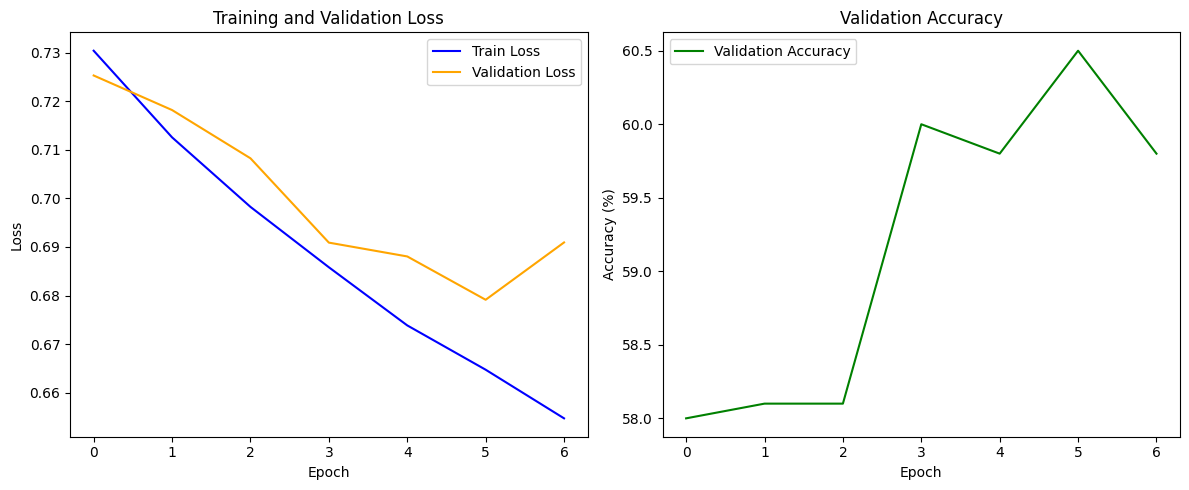

In [10]:
import matplotlib.pyplot as plt

# After training the model
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Plotting the training and validation losses
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the validation accuracies
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')


Test Loss: 0.6666 | Test Acc: 62.25%


In [12]:
torch.save(model.state_dict(), 'lstm_with_attention_model.pth')